In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import Counter
from sklearn.metrics import log_loss
import xgboost as xgb
import pickle

In [30]:
train = pd.read_csv('Data/cleaned_train_ver2.csv')
# test = pd.read_csv('Data/cleaned_test_ver2.csv')

In [31]:
train.columns

Index(['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age',
       'Join_Dt', 'Is_New_Cust', 'Cust_Since', 'Relship_Status',
       'Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg', 'Cust_Relship_Type_Mth_Beg',
       'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel',
       'Deceased_Flg', 'Address_Type', 'Cust_Province_Cd',
       'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
       'Cust_Segment', 'Savings_Acct', 'Guarantees', 'Cur_Acct',
       'Derivative_Acct', 'Payroll_Acct', 'Junior_Acct', 'Mas_Particular_Acct',
       'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
       'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds',
       'Mortgage', 'Pension1', 'Loans', 'Taxes', 'Credit_Card', 'Securities',
       'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit'],
      dtype='object')

In [32]:
products = list(train.columns[24:])

1. We will __exclude__ Status_Dt, Cust_ID, Lst_Dt_Primary_Cust and Cust_Province_Name because these are either not useful or redundant.
2. __Transformations__
    1. One hot encode below 10 features:
        - Emp_Status, Cust_Sex, Is_New_Cust, Relship_Status, Cust_Relship_Type_Mth_Beg, Residence_Ctry, Is_Foreigner, Is_Spouse_Emp, Deceased_Flg and Cust_Segment.
    2. Label encode Cust_Ctry and Join_Channel.
    3. Log transform Gross_HHLD_Income.
3. To __save space__ we will convert the below 6 features to int.
    1. Age, Cust_Since, Cust_Type_Mth_Beg, Address_Type, Cust_Province_Cd, Cust_Active_Status
4. __Feature Engineering__
    1. Using Status_Dt and Join_Dt we will create 3 new features.
        - Month 
        - Year 
        - Number of months since 2015 
    2. Create a new feature to indicate the Status_Dt in terms of Join_Dt (Status_Dt - Join_Dt)
    3. Create a new feature to indicate whether the household income belongs to top 100.


In [33]:
def print_multi_log_loss_for_random_model(y_train, y_validate):
    #when using a subset of the train dataset it is possible that we may not have all the classes in the train set
    #so instead of using 24 as the size calculate it
    size = len(y_validate.value_counts())
    predicted_y = np.zeros((len(y_validate), size))
    train_len = len(y_train)
    test_len = len(y_validate)
    
    for i in range(test_len):
        rand_probs = np.random.rand(1,size)
        predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    print("Multi Log loss on Test Data using Random Model is {}. Our model should get a logloss of less than this.".\
          format(log_loss(Xy_validate.y, predicted_y, eps=1e-15)))

def print_class_distributions(y_train, y_validate, number_of_classes):
    print("-"*10, "Distribution of output variable in train data", "-"*10)
    train_distr = Counter(y_train)
    train_len = len(y_train)
    for i in range(0, number_of_classes):
        print("Class {}: {};".format(i, int(train_distr[i])/train_len), end =" ")
    print('\n')
    
    print("-"*10, "Distribution of output variable in train data", "-"*10)
    test_distr = Counter(y_validate)
    test_len = len(y_validate)
    for i in range(0,number_of_classes):
        print("Class {}: {};".format(i, int(test_distr[i])/test_len), end =" ")
    print('\n')

def label_encode(df, train_cols, col_name):
    df[col_name] = df[col_name].astype('str')
    if col_name in label_encoders: # check
        df[col_name] = label_encoders[col_name].transform(df[col_name])
    else: # train
        label_encoders[col_name] = LabelEncoder()
        df[col_name] = label_encoders[col_name].fit_transform(df[col_name])
    train_cols.append(col_name)
    
def encode_top(s, count=100, dtype=np.int8):
    uniqs, freqs = np.unique(s, return_counts=True)
    #sort in descending order. top will contain a list similar to 
    #[(1.0, 3022340),
    #  (451931.22, 5936),
    #  (463625.16, 1854),
    #  (181042.2, 1584),
    #  (128318.52, 1495)]
    #use only top 100
    top = sorted(zip(uniqs,freqs), key=lambda vk: vk[1], reverse = True)[:count]
    #top contains tuples made up of (hhld, frequency). top_map is a dictionary containing hhld income as key and its index
    #as value.
    #{1.0: 1,
    #  451931.22: 2,
    #  463625.16: 3,
    #  181042.2: 4,
    #  128318.52: 5}
    top_map = {uf[0]: l+1 for uf, l in zip(top, range(len(top)))}
    #if the hhld income is in the top 100 use the index value from dictionary otherwise default it to 0
    return s.map(lambda x: top_map.get(x, 0)).astype(dtype)

def create_lag_df(df, step):
    with Timer("make lag{} DF".format(step)):
        lag_df = pd.DataFrame()
        lag_df["Cust_ID"] = df["Cust_ID"]
        lag_df["Mths_Since_2015"] = df["Mths_Since_2015"].map(lambda x: x+step).astype(np.int8)
        lag_features = ["{}_lag{}".format(prod, step) for prod in products]
        for product, lag_feature in zip(products, lag_features):
            lag_df[lag_feature] = df[product]
    return lag_df, tuple(lag_features)

def join_with_lag_df(df, lag_dfs):
    for i, lag_df in enumerate(lag_dfs):
        with Timer("join train with lag{}".format(i+1)):
            #select only the clients who have made purchases during lag1 period. 
            #for all the other periods use the same clients as in lag1 period
            how = "inner" if i == 0 else "left"
            assert set(df.columns.values.tolist()) & set(lag_df.columns.values.tolist()) == \
                                                     set(["Cust_ID", "Mths_Since_2015"])
            print("# of records before joining with lag df is {}".format(len(df)))

            df = df.merge(lag_df, on=["Cust_ID", "Mths_Since_2015"], how=how)

            #change datatypes for products
            for f in set(lag_df.columns.values.tolist()) - set(["Cust_ID", "Mths_Since_2015"]):
                df[f] = df[f].astype(np.float16)
            print("# of records after joining with lag df is {}".format(len(df)))
    return df

In [34]:
# shows a plot of the 15 most importance features
def plot_feature_importances(df):
     # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

def plot_xgb_fi(model):
    features=[]
    feature_importance_values = []
    for k, v in model.get_fscore().items():
        features.append(k)
        feature_importance_values.append(v)
    fi = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
    fi_sorted = plot_feature_importances(fi)
    return fi_sorted

In [35]:
def apply_transformations(df):
    train_cols = []
    with Timer("apply transformations"):
        #one hot encode columns
        one_hot_cols = ['Emp_Status', 'Cust_Sex', 'Is_New_Cust', 'Relship_Status', 'Cust_Relship_Type_Mth_Beg', \
                       'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Deceased_Flg', 'Cust_Segment']
        #apply one hot encoding and change the output datatype to be int8
        one_hot_df = pd.get_dummies(df[one_hot_cols], columns=one_hot_cols, dtype=np.int8)
        #combine the one_hot encoded dataframe to the train dataset
        df = df.join(one_hot_df)
        train_cols.extend(list(one_hot_df.columns))

        #label encode columns
        label_encode_cols = ['Cust_Ctry', 'Join_Channel']
        for col in label_encode_cols:
            label_encode(df, train_cols, col)
            
        #convert datatypes
        df["Age"] = df["Age"].astype(np.int16)
        train_cols.append('Age')
        
        cols=['     NA', np.nan]
        df.loc[df["Cust_Since"].isin(cols), "Cust_Since"] = 0.0
        df["Cust_Since"] = df["Cust_Since"].astype(np.int16)
#         df["Cust_Since"] = df["Cust_Since"].map(lambda x: 0.0 if x < 0 else x).astype(np.int16)
        train_cols.append("Cust_Since")
        
        df["Cust_Type_Mth_Beg"] = df["Cust_Type_Mth_Beg"].map(lambda x: 5.0 if x == "P" else x).astype(np.int8)
        train_cols.append("Cust_Type_Mth_Beg")

        df["Address_Type"] = df["Address_Type"].astype(np.int8)
        train_cols.append("Address_Type")
        
        df["Cust_Province_Cd"] = df["Cust_Province_Cd"].astype(np.int8)
        train_cols.append("Cust_Province_Cd")
        
        df["Cust_Active_Status"] = df["Cust_Active_Status"].astype(np.int8)
        train_cols.append("Cust_Active_Status")
        
        #feature engineering
        #Using Status_Dt and Join_Dt create 3 new features - Month, Year, number of months since 2015
        df["Status_Dt_Month"] = df["Status_Dt"].map(lambda x: int(x.split("-")[1])).astype(np.int8)
        train_cols.append("Status_Dt_Month")
        df["Status_Dt_Year"] = df["Status_Dt"].map(lambda x: float(x.split("-")[0])).astype(np.int16)
        train_cols.append("Status_Dt_Year")
        df["Mths_Since_2015"] = df["Status_Dt"].map(date_to_int).astype(np.int8)
        train_cols.append("Mths_Since_2015")
        df["Status_Dt_Float"] = df["Status_Dt"].map(date_to_float)
        train_cols.append("Status_Dt_Float")
                
        #Join Date
        df["Join_Dt_Month"] = df["Join_Dt"].map(lambda x: float(x.split("-")[1])).astype(np.int8)
        train_cols.append("Join_Dt_Month")
        df["Join_Dt_Year"] = df["Join_Dt"].map(lambda x: float(x.split("-")[0])).astype(np.int16)
        train_cols.append("Join_Dt_Year")
        df["Join_Dt_Float"] = df["Join_Dt"].map(date_to_float)
        train_cols.append("Join_Dt_Float")
    
        df["Hist_Dt"] = df["Status_Dt_Float"] - df["Join_Dt_Float"]
        train_cols.append("Hist_Dt")
        
        #Gross HHLD Income
        df["Top_Gross_HHLD_Income"] = encode_top(df["Gross_HHLD_Income"])
        train_cols.append("Top_Gross_HHLD_Income")
        df['Gross_HHLD_Income'] = np.log(df.Gross_HHLD_Income)
        train_cols.append("Gross_HHLD_Income")
        
    return df, tuple(train_cols)

In [36]:
def create_lag_features(df, train_cols, no_of_lags=2):
    lag_dfs = []

    lag1_features = None

    for step in range(1, no_of_lags+1):
        lag_df, lag_features = create_lag_df(df, step)
        
        lag_dfs.append(lag_df)
        train_cols += lag_features
        
        if step == 1:
            lag1_features = lag_features

    return lag_dfs, train_cols, lag1_features

In [37]:
def create_min_max_std_dev_features(train_df, train_cols):
    lag=6
    start=2
    lag_combinations = [(1, i) for i in range(start, lag+1, 2)]
        
    for prod in products:
        for begin, end in lag_combinations:
            std_dev_cols = ["%s_lag%s" % (prod, i) for i in range(begin,end+1)]
            std_df = train_df.as_matrix(columns=std_dev_cols)
            std_dev_feats = "%s_std_%s_%s" % (prod,begin,end)
            train_df[std_dev_feats] = np.nanstd(std_df, axis=1) 

            train_cols += (std_dev_feats,)

    for prod in products:
        for begin, end in lag_combinations:
            min_max_cols = ["%s_lag%s" % (prod, i) for i in range(begin,end+1)]
            min_max_df = train_df.as_matrix(columns=min_max_cols)

            min_feats = "%s_min_%s_%s"%(prod,begin,end)
            train_df[min_feats] = np.nanmin(min_max_df, axis=1).astype(np.int8)

            max_feats = "%s_max_%s_%s"%(prod,begin,end)
            train_df[max_feats] = np.nanmax(min_max_df, axis=1).astype(np.int8)

            train_cols += (min_feats,max_feats,)
    return train_df, train_cols

In [38]:
def prepare_train_test_split(df, train_cols, test_date, cv):
    test_date_mths_since_2015 = date_to_int(test_date)
    train_df = df[df.Mths_Since_2015 < test_date_mths_since_2015]
    test_df = df[df.Mths_Since_2015 == test_date_mths_since_2015]
#     print(sorted(set(train_df.columns.values.tolist())))
#     print(len(train_df.columns.values.tolist()), len(set(train_df.columns.values.tolist())))
#     print(len(train_cols),len(set(train_cols)))

    X = []
    y = []
    # Build X and y. 
    # For each product select customers who bought a product that month and use only that data to create X
    # and correspondingly create y with just zeroes. For the first product y will be zeroes, for the next product it will 
    # be 1, etc. This will help us to treat this as a multi-class classification problem.
    for i, curr_product in enumerate(products):
        prev_product = curr_product + "_lag1"
        #select customers who has bought a product this month - that means
        #that product will be 1 and prev_product will be 0
        prX = train_df[(train_df[curr_product] == 1) & (train_df[prev_product] == 0)]
        #build an array of zeroes, if we had found two customers in the above step
        #then we will be creating an array with 2 ones because we want to be able to set this up
        #as a multiclass classification problem. The first product will be 1, the next will be 2, etc.
        prY = np.zeros(prX.shape[0], dtype=np.int8) + i
        X.append(prX)
        y.append(prY)
#         print(product, prX.shape)
    #X is potentially made up of 24 items, 1 item for each of the product
    #Each item is made up of customers who bought that product in the current month
    #convert X, which is a list into a dataframe
    Xy = pd.concat(X)
    #Y is also potentially made up of 24 items, 1 item for each product
    #Each item is made up of array that is equal to the number of customer who bought that product in the current month
    #if 2 customers bought the first product, the first array will be made up of 2 elements containing 0s
    #if 4 customers bought the second product, the second array will be made up of 4 elements containing 1s
    #when we do hstack on Y the length of Y will be equal to the sum of customers who bought a product
    #We can treat this as a multi-class classification problem
    y = np.hstack(y)
    Xy["y"] = y
#     Xy["url"] = np.zeros(len(XY), dtype=np.int8)

    del train_df
    del df

#     #create a new feature combining cust_id and status_date
#     Xy["Cust_ID_Status_Dt"] = Xy["Cust_ID"].astype(str) + Xy["Status_Dt"]
#     uniqs, counts = np.unique(Xy["Cust_ID_Status_Dt"], return_counts=True)
#     #1==count*log(w)
#     weights = np.exp(1/counts - 1)
#     print(np.unique(counts, return_counts=True))
#     print(np.unique(weights, return_counts=True))
#     wdf = pd.DataFrame()
#     wdf["ncodepers_fecha_dato"] = uniqs
#     wdf["counts"] = counts
#     wdf["weight"] = weights
#     print("before merge", len(Xy))
#     Xy = Xy.merge(wdf, on="ncodepers_fecha_dato")
#     print("after merge", len(Xy))

    print('Shape of train and validate dataset is {}'.format(Xy.shape))

    #randomly select 80% as train and 20% as validation datasets
    mask = np.random.rand(len(Xy)) < 0.8
    Xy_train = Xy[mask]
    Xy_validate = Xy[~mask]

    return Xy_train, Xy_validate

#     with Timer("prepare test data"):
#         test_df["y"] = test_df["Cust_ID"]
# #         test_df["url"] = np.zeros(len(test_df), dtype=np.int8)
# #         test_df["weight"] = np.ones(len(test_df), dtype=np.int8)
# #         Y_lag = test_df.as_matrix(columns=prod_train_cols)
#         C = test_df.as_matrix(columns=["Cust_ID"])
#         for prod in products:
#             prev = prod + "_lag1"
#             padd = prod + "_add"
#             test_df[padd] = test_df[prod] - test_df[prev]
#         test_add_mat = test_df.as_matrix(columns=[prod + "_add" for prod in products])
#         test_add_cust_list = [list() for i in range(len(C))]
#         assert test_add_mat.shape == (len(C), len(products))
#         count = 0
#         for c in range(len(C)):
#             for p in range(len(products)):
#                 if test_add_mat[c,p] > 0:
#                     test_add_cust_list[c].append(p)
#                     count += 1

In [39]:
def prepare_test_data(df, test_date, lag1_features):
    test_date_mths_since_2015 = date_to_int(test_date)
    test_df = df[df.Mths_Since_2015 == test_date_mths_since_2015]
    
    with Timer("prepare test data"):
#         test_df["y"] = test_df["Cust_ID"]
#         test_df["url"] = np.zeros(len(test_df), dtype=np.int8)
#         test_df["weight"] = np.ones(len(test_df), dtype=np.int8)
        y_lag = test_df.as_matrix(columns = lag1_features)
        #get all customer ids
        cust_ids = test_df.as_matrix(columns=["Cust_ID"])
        for prod in products:
            prev = prod + "_lag1"
            padd = prod + "_added"
            #this will tell us what was added during the current month
            test_df[padd] = test_df[prod] - test_df[prev]
            
        products_added_during_each_month = test_df.as_matrix(columns=[prod + "_added" for prod in products])
        #create an empty list. if there are 5 customers, this will create
        #[[], [], [], [], []]. Each inner list represents a customers.
        #This will contain the product ids of products bought by customers. if this list contains
        #[[2], [4], [], [], []] - this means customer 1 bought product 2 and customer 2 bought product 4
        cust_list_of_products_bought = [list() for i in range(len(cust_ids))]
        
        assert products_added_during_each_month.shape == (len(cust_ids), len(products))
        count = 0
        for cust_index in range(len(cust_ids)):
            for product_id in range(len(products)):
                if products_added_during_each_month[cust_index, product_id] > 0:
                    cust_list_of_products_bought[cust_index].append(product_id)
                    count += 1
    #Note:cust_list_of_products_bought will contain a list of at most 24 products for a customer
    #the product_ids will be from 0 to 23
    return cust_list_of_products_bought, y_lag

In [40]:
def run_xgb_model(Xy_train, Xy_validate, train_cols):
    params={}
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss'
    params['eta'] = 0.1
    params['max_depth'] = 8
    params['n_estimators'] = 350,
    params['num_class'] = len(products)

    X_train = Xy_train.as_matrix(columns=train_cols)
    y_train = Xy_train.as_matrix(columns=["y"])
    train = xgb.DMatrix(X_train, label=y_train, feature_names = train_cols)

    X_validate = Xy_validate.as_matrix(columns=train_cols)
    y_validate = Xy_validate.as_matrix(columns=["y"])
    validate = xgb.DMatrix(X_validate, label=y_validate, feature_names=train_cols)

    evallist  = [(train,'train'), (validate,'eval')]
    model = xgb.train(params, train, 1000, evals=evallist, early_stopping_rounds=20, verbose_eval=10)

    xgdmat = xgb.DMatrix(X_train,y_train)
    predict_y = model.predict(validate, ntree_limit=model.best_ntree_limit)
    xgb_log_loss = log_loss(y_validate, predict_y, eps=1e-15, labels=list(range(len(products))))
    print("The test log loss is:{}".format(xgb_log_loss))
    
    fi_sorted= plot_xgb_fi(model)
    return predict_y, fi_sorted, model, xgb_log_loss

In [ ]:
# temp_df = train.head(100000)
xgb_log_loss = {}
label_encoders = {}
train, train_cols = apply_transformations(train)
with Timer("save data"):
    train.to_pickle("Data/train_transformed_data.pickle")
    pickle.dump((train_cols), open("Data/train_cols.pickle", "wb"))
    
lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags=2)
train = join_with_lag_df(train, lag_dfs)
test_date = '2016-05-28'
Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
y_true = test_cust_list_of_products_bought
del test_cust_list_of_products_bought
print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
#logloss can be between 0 and infinity. Interpretability with logloss is not good.
#We know 0 indicates that our model is doing very well but it is difficult to interpret the upper bound. 
#So we will score the test data using a random model to understand the upper bound for our model
print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
xgb_log_loss['lags2'] = xgb_loss
# map7xgb = mapk(y_true, y_predict, 7, 0.0)

restore data...
restore data: cpu 53.84, time 53.82

make lag1 DF...
make lag1 DF: cpu 6.90, time 6.92

make lag2 DF...
make lag2 DF: cpu 7.00, time 7.00

make lag3 DF...
make lag3 DF: cpu 7.84, time 7.84

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 78.64, time 78.64

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 67.55, time 67.55

join train with lag3...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag3: cpu 68.00, time 68.00

Shape of train and validate dataset is (525867, 157)
prepare test data...


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


prepare test data: cpu 11.32, time 11.33

---------- Distribution of output variable in train data ----------
Class 0: 2.3775106512477176e-06; Class 1: 9.51004260499087e-06; Class 2: 0.12431289942178941; Class 3: 0.0002282410225197809; Class 4: 0.06583089242239805; Class 5: 0.0008559038344491784; Class 6: 0.011942236001217285; Class 7: 0.006775905356055995; Class 8: 0.004381752130249544; Class 9: 0.005865318776628119; Class 10: 0.0004636145769933049; Class 11: 0.023972439896530737; Class 12: 0.04485411594643944; Class 13: 0.006942331101643336; Class 14: 0.00014027312842361533; Class 15: 0.0011293175593426658; Class 16: 0.00026865870359099207; Class 17: 0.017034863816189898; Class 18: 0.12353069841752891; Class 19: 0.008894267346317711; Class 20: 0.00011887553256238588; Class 21: 0.12979543898356666; Class 22: 0.15049880173463176; Class 23: 0.272151266737675; 

---------- Distribution of output variable in train data ----------
Class 0: 0.0; Class 1: 0.0; Class 2: 0.12314386418263522; C

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.63465	eval-mlogloss:2.63953
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.54167	eval-mlogloss:1.56076
[20]	train-mlogloss:1.25023	eval-mlogloss:1.27728
[30]	train-mlogloss:1.12329	eval-mlogloss:1.15733
[40]	train-mlogloss:1.05766	eval-mlogloss:1.09843
[50]	train-mlogloss:1.01943	eval-mlogloss:1.06696
[60]	train-mlogloss:0.994791	eval-mlogloss:1.04894
[70]	train-mlogloss:0.978063	eval-mlogloss:1.03855
[80]	train-mlogloss:0.966271	eval-mlogloss:1.0325
[90]	train-mlogloss:0.957107	eval-mlogloss:1.02885
[100]	train-mlogloss:0.949868	eval-mlogloss:1.02671
[110]	train-mlogloss:0.943592	eval-mlogloss:1.02554
[120]	train-mlogloss:0.938066	eval-mlogloss:1.0249
[130]	train-mlogloss:0.932778	eval-mlogloss:1.02473
[140]	train-mlogloss:0.927917	eval-mlogloss:1.02482
[150]	train-mlogloss:0.922905	eval-mlogloss:1.02499
Stopping. Best iteration:
[133]	trai

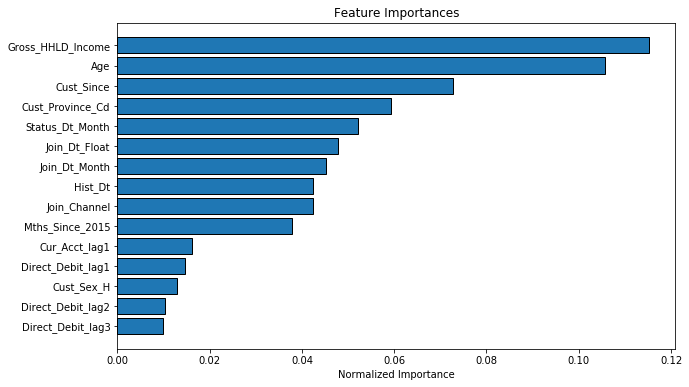

In [14]:
#no_of_lags=3
with Timer("restore data"):
        train = pd.read_pickle("Data/train_transformed_data.pickle")
        train_cols = pickle.load(open("Data/train_cols.pickle", "rb"))
lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags=3)
train = join_with_lag_df(train, lag_dfs)
test_date = '2016-05-28'
Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
y_true = test_cust_list_of_products_bought
del test_cust_list_of_products_bought
print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
xgb_log_loss['lags3'] = xgb_loss

restore data...
restore data: cpu 53.99, time 53.99

make lag1 DF...
make lag1 DF: cpu 6.90, time 6.90

make lag2 DF...
make lag2 DF: cpu 8.47, time 8.47

make lag3 DF...
make lag3 DF: cpu 9.19, time 9.19

make lag4 DF...
make lag4 DF: cpu 8.66, time 8.66

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 90.30, time 90.30

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 65.54, time 65.54

join train with lag3...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag3: cpu 77.89, time 77.89

join train with lag4...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag4: cpu 82.54, time 82.54

Shape of train and validate dataset is (525867, 181)
pr

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


prepare test data: cpu 12.02, time 12.02

---------- Distribution of output variable in train data ----------
Class 0: 2.376781694978098e-06; Class 1: 9.507126779912392e-06; Class 2: 0.12400145459039733; Class 3: 0.00025906920475261266; Class 4: 0.06616960238819025; Class 5: 0.0008603949735820714; Class 6: 0.012090688482353585; Class 7: 0.006840377718146966; Class 8: 0.004347133720114941; Class 9: 0.005818361589306383; Class 10: 0.0004991241559454006; Class 11: 0.024174246619622235; Class 12: 0.044942565070340855; Class 13: 0.006978231056455696; Class 14: 0.0001188390847489049; Class 15: 0.001140855213589487; Class 16: 0.0002685763315325251; Class 17: 0.017034394407908028; Class 18: 0.12368534262496524; Class 19: 0.008855888595488392; Class 20: 0.0001259694298338392; Class 21: 0.1299529159546225; Class 22: 0.15046929554567343; Class 23: 0.27135478933395446; 

---------- Distribution of output variable in train data ----------
Class 0: 0.0; Class 1: 0.0; Class 2: 0.12438885189765053; Cl

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.63273	eval-mlogloss:2.6342
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.53567	eval-mlogloss:1.54619
[20]	train-mlogloss:1.24118	eval-mlogloss:1.25903
[30]	train-mlogloss:1.11224	eval-mlogloss:1.13707
[40]	train-mlogloss:1.0455	eval-mlogloss:1.07709
[50]	train-mlogloss:1.00675	eval-mlogloss:1.04488
[60]	train-mlogloss:0.981989	eval-mlogloss:1.02654
[70]	train-mlogloss:0.9653	eval-mlogloss:1.016
[80]	train-mlogloss:0.953376	eval-mlogloss:1.00982
[90]	train-mlogloss:0.943901	eval-mlogloss:1.00604
[100]	train-mlogloss:0.936568	eval-mlogloss:1.00401
[110]	train-mlogloss:0.929901	eval-mlogloss:1.00276
[120]	train-mlogloss:0.924343	eval-mlogloss:1.00217
[130]	train-mlogloss:0.918987	eval-mlogloss:1.00191
[140]	train-mlogloss:0.91399	eval-mlogloss:1.00208
Stopping. Best iteration:
[129]	train-mlogloss:0.919399	eval-mlogloss:1.00188

The test log l

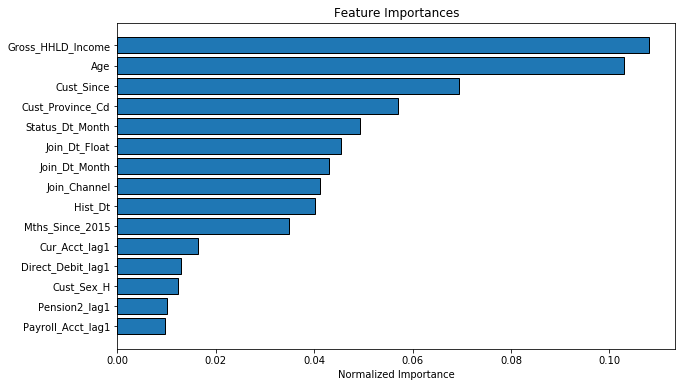

In [15]:
#no_of_lags=4
with Timer("restore data"):
        train = pd.read_pickle("Data/train_transformed_data.pickle")
        train_cols = pickle.load(open("Data/train_cols.pickle", "rb"))
lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags=4)
train = join_with_lag_df(train, lag_dfs)
test_date = '2016-05-28'
Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
y_true = test_cust_list_of_products_bought
del test_cust_list_of_products_bought
print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
xgb_log_loss['lags4'] = xgb_loss

**************************Lag 5-Start************************************
Lag 5...
restore data...
restore data: cpu 55.12, time 55.12

make lag1 DF...
make lag1 DF: cpu 7.80, time 7.80

make lag2 DF...
make lag2 DF: cpu 11.61, time 11.61

make lag3 DF...
make lag3 DF: cpu 11.89, time 11.89

make lag4 DF...
make lag4 DF: cpu 11.88, time 11.88

make lag5 DF...
make lag5 DF: cpu 10.70, time 10.70

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 84.32, time 84.32

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 68.98, time 68.98

join train with lag3...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag3: cpu 75.05, time 75.04

join train with lag4...
# of records before joining with lag df is 12682421
# of reco

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


prepare test data: cpu 11.97, time 11.97

Multi Log loss on Test Data using Random Model is 3.387696144992752. Our model should get a logloss of less than this.


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.63083	eval-mlogloss:2.63261
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.52955	eval-mlogloss:1.54256
[20]	train-mlogloss:1.23366	eval-mlogloss:1.25457
[30]	train-mlogloss:1.10394	eval-mlogloss:1.13232
[40]	train-mlogloss:1.03668	eval-mlogloss:1.07237
[50]	train-mlogloss:0.997002	eval-mlogloss:1.0398
[60]	train-mlogloss:0.971779	eval-mlogloss:1.02153
[70]	train-mlogloss:0.95452	eval-mlogloss:1.01099
[80]	train-mlogloss:0.941946	eval-mlogloss:1.00467
[90]	train-mlogloss:0.932537	eval-mlogloss:1.00097
[100]	train-mlogloss:0.924751	eval-mlogloss:0.998754
[110]	train-mlogloss:0.918129	eval-mlogloss:0.997531
[120]	train-mlogloss:0.911909	eval-mlogloss:0.996959
[130]	train-mlogloss:0.906263	eval-mlogloss:0.996887
[140]	train-mlogloss:0.901148	eval-mlogloss:0.997167
Stopping. Best iteration:
[126]	train-mlogloss:0.908438	eval-mlogloss:0.996858

Th

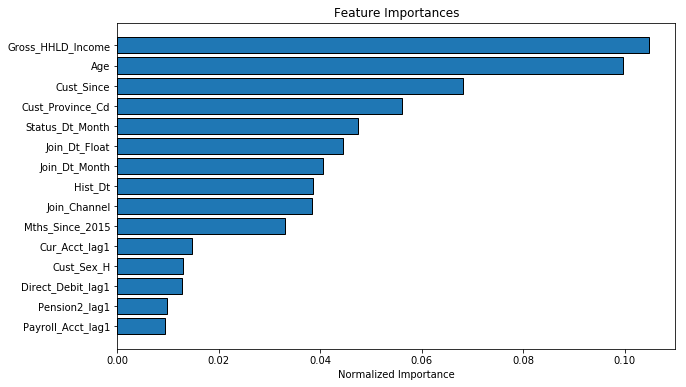

Lag 5: cpu 3254.83, time 3254.83

**************************Lag 5-End**************************************
**************************Lag 6-Start************************************
Lag 6...
restore data...
restore data: cpu 53.04, time 53.03

make lag1 DF...
make lag1 DF: cpu 6.48, time 6.49

make lag2 DF...
make lag2 DF: cpu 6.96, time 6.95

make lag3 DF...
make lag3 DF: cpu 8.35, time 8.36

make lag4 DF...
make lag4 DF: cpu 10.72, time 10.72

make lag5 DF...
make lag5 DF: cpu 9.88, time 9.88

make lag6 DF...
make lag6 DF: cpu 11.57, time 11.56

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 96.06, time 96.06

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 66.51, time 66.52

join train with lag3...
# of records before joining with lag df is 12682421
# of records after joining

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


prepare test data: cpu 11.78, time 11.78

Multi Log loss on Test Data using Random Model is 3.3878282815294765. Our model should get a logloss of less than this.


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.62923	eval-mlogloss:2.63142
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.52494	eval-mlogloss:1.54005
[20]	train-mlogloss:1.22785	eval-mlogloss:1.25122
[30]	train-mlogloss:1.0971	eval-mlogloss:1.12792
[40]	train-mlogloss:1.02892	eval-mlogloss:1.06708
[50]	train-mlogloss:0.988943	eval-mlogloss:1.0338
[60]	train-mlogloss:0.963351	eval-mlogloss:1.01492
[70]	train-mlogloss:0.946262	eval-mlogloss:1.00425
[80]	train-mlogloss:0.933674	eval-mlogloss:0.997847
[90]	train-mlogloss:0.924117	eval-mlogloss:0.993966
[100]	train-mlogloss:0.916183	eval-mlogloss:0.991609
[110]	train-mlogloss:0.909423	eval-mlogloss:0.990287
[120]	train-mlogloss:0.903458	eval-mlogloss:0.989715
[130]	train-mlogloss:0.898136	eval-mlogloss:0.989751
[140]	train-mlogloss:0.892732	eval-mlogloss:0.98989
Stopping. Best iteration:
[122]	train-mlogloss:0.902282	eval-mlogloss:0.989645

T

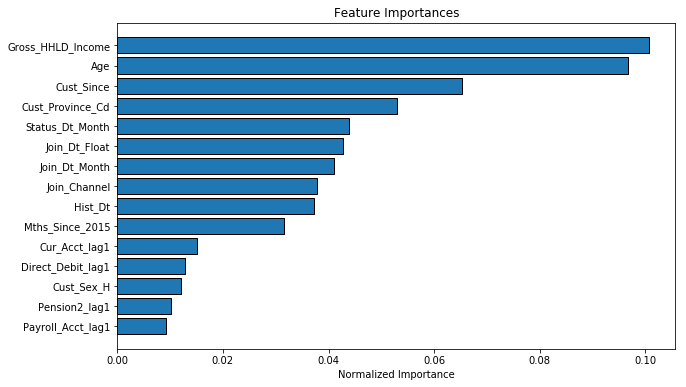

Lag 6: cpu 3549.32, time 3549.32

**************************Lag 6-End**************************************
**************************Lag 7-Start************************************
Lag 7...
restore data...
restore data: cpu 71.86, time 71.84

make lag1 DF...
make lag1 DF: cpu 6.55, time 6.55

make lag2 DF...
make lag2 DF: cpu 5.89, time 5.89

make lag3 DF...
make lag3 DF: cpu 9.14, time 9.15

make lag4 DF...
make lag4 DF: cpu 8.45, time 8.44

make lag5 DF...
make lag5 DF: cpu 11.00, time 11.00

make lag6 DF...
make lag6 DF: cpu 10.53, time 10.53

make lag7 DF...
make lag7 DF: cpu 16.93, time 16.94

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 93.01, time 93.02

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 60.62, time 60.62

join train with lag3...
# of records before joini

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


prepare test data: cpu 13.36, time 13.35

Multi Log loss on Test Data using Random Model is 3.4367370754832502. Our model should get a logloss of less than this.


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.62883	eval-mlogloss:2.63333
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.52301	eval-mlogloss:1.54046
[20]	train-mlogloss:1.22566	eval-mlogloss:1.2509
[30]	train-mlogloss:1.09486	eval-mlogloss:1.12742
[40]	train-mlogloss:1.02599	eval-mlogloss:1.06574
[50]	train-mlogloss:0.985487	eval-mlogloss:1.03225
[60]	train-mlogloss:0.959812	eval-mlogloss:1.01315
[70]	train-mlogloss:0.942289	eval-mlogloss:1.00224
[80]	train-mlogloss:0.929442	eval-mlogloss:0.995653
[90]	train-mlogloss:0.919443	eval-mlogloss:0.991494
[100]	train-mlogloss:0.91153	eval-mlogloss:0.98938
[110]	train-mlogloss:0.904804	eval-mlogloss:0.988127
[120]	train-mlogloss:0.898758	eval-mlogloss:0.987618
[130]	train-mlogloss:0.893364	eval-mlogloss:0.987485
[140]	train-mlogloss:0.88809	eval-mlogloss:0.98747
Stopping. Best iteration:
[128]	train-mlogloss:0.894265	eval-mlogloss:0.987426

The

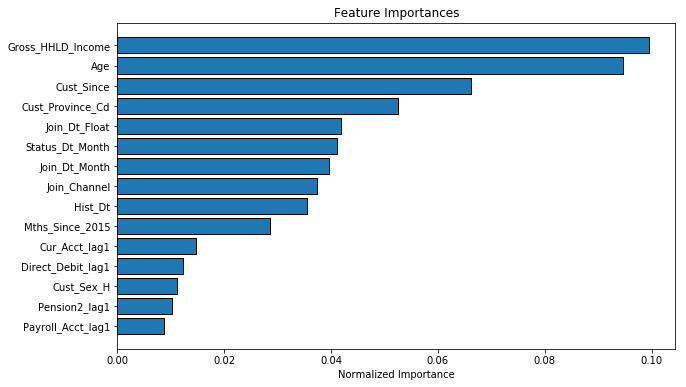

Lag 7: cpu 4095.98, time 4095.97

**************************Lag 7-End**************************************
**************************Lag 8-Start************************************
Lag 8...
restore data...
restore data: cpu 56.61, time 56.61

make lag1 DF...
make lag1 DF: cpu 10.13, time 10.14

make lag2 DF...
make lag2 DF: cpu 8.16, time 8.17

make lag3 DF...
make lag3 DF: cpu 10.07, time 10.06

make lag4 DF...
make lag4 DF: cpu 10.38, time 10.39

make lag5 DF...
make lag5 DF: cpu 9.36, time 9.36

make lag6 DF...
make lag6 DF: cpu 10.00, time 10.00

make lag7 DF...
make lag7 DF: cpu 13.32, time 13.31

make lag8 DF...
make lag8 DF: cpu 10.88, time 10.87

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 83.82, time 83.83

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 66.21, time

MemoryError: 

In [16]:
lags = [5, 6, 7, 8, 9, 10, 11, 12]
for no_of_lags in lags:
    print('**************************Lag {}-Start************************************'.format(no_of_lags))
    with Timer("Lag {}".format(no_of_lags)):
        with Timer("restore data"):
                train = pd.read_pickle("Data/train_transformed_data.pickle")
                train_cols = pickle.load(open("Data/train_cols.pickle", "rb"))
        lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags)
        train = join_with_lag_df(train, lag_dfs)
        test_date = '2016-05-28'
        Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
        test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
        y_true = test_cust_list_of_products_bought
        del test_cust_list_of_products_bought
#         print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
        print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
        y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
        xgb_log_loss['lags'+str(no_of_lags)] = xgb_loss
    print('**************************Lag {}-End**************************************'.format(no_of_lags))

**************************Lag 8-Start************************************
Lag 8...
restore data...
restore data: cpu 56.77, time 56.75

make lag1 DF...
make lag1 DF: cpu 6.70, time 6.70

make lag2 DF...
make lag2 DF: cpu 6.60, time 6.60

make lag3 DF...
make lag3 DF: cpu 7.67, time 7.67

make lag4 DF...
make lag4 DF: cpu 7.83, time 7.83

make lag5 DF...
make lag5 DF: cpu 8.56, time 8.57

make lag6 DF...
make lag6 DF: cpu 8.72, time 8.73

make lag7 DF...
make lag7 DF: cpu 9.31, time 9.29

make lag8 DF...
make lag8 DF: cpu 10.76, time 10.77

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 91.42, time 91.42

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 60.68, time 60.67

join train with lag3...
# of records before joining with lag df is 12682421
# of records after joining with la

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


prepare test data: cpu 11.56, time 11.56

Multi Log loss on Test Data using Random Model is 3.438211021980402. Our model should get a logloss of less than this.


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.62931	eval-mlogloss:2.63221
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.52306	eval-mlogloss:1.53803
[20]	train-mlogloss:1.22466	eval-mlogloss:1.24795
[30]	train-mlogloss:1.09305	eval-mlogloss:1.12372
[40]	train-mlogloss:1.02438	eval-mlogloss:1.06227
[50]	train-mlogloss:0.983987	eval-mlogloss:1.02871
[60]	train-mlogloss:0.957949	eval-mlogloss:1.00958
[70]	train-mlogloss:0.940232	eval-mlogloss:0.998508
[80]	train-mlogloss:0.927204	eval-mlogloss:0.991868
[90]	train-mlogloss:0.91759	eval-mlogloss:0.988106
[100]	train-mlogloss:0.90953	eval-mlogloss:0.985759
[110]	train-mlogloss:0.902984	eval-mlogloss:0.984605
[120]	train-mlogloss:0.897214	eval-mlogloss:0.984005
[130]	train-mlogloss:0.891697	eval-mlogloss:0.983976
[140]	train-mlogloss:0.88624	eval-mlogloss:0.984144
Stopping. Best iteration:
[127]	train-mlogloss:0.893287	eval-mlogloss:0.983907



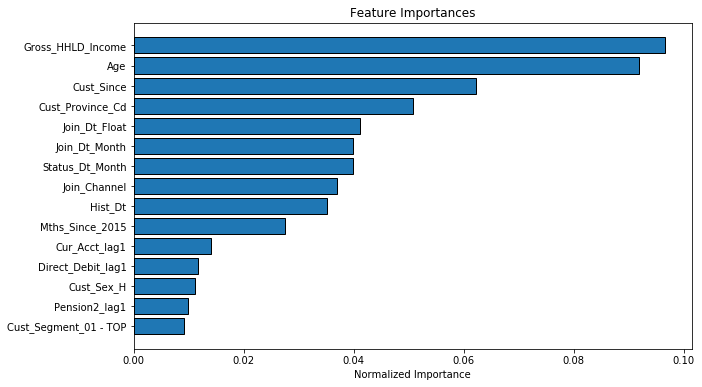

Lag 8: cpu 4418.42, time 4418.42



NameError: name 'xgb_log_loss' is not defined

In [12]:
lags = [8, 9, 10]
for no_of_lags in lags:
    print('**************************Lag {}-Start************************************'.format(no_of_lags))
    with Timer("Lag {}".format(no_of_lags)):
        with Timer("restore data"):
                train = pd.read_pickle("Data/train_transformed_data.pickle")
                train_cols = pickle.load(open("Data/train_cols.pickle", "rb"))
        lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags)
        train = join_with_lag_df(train, lag_dfs)
        test_date = '2016-05-28'
        Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
        test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
        y_true = test_cust_list_of_products_bought
        del test_cust_list_of_products_bought
#         print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
        print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
        y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
        xgb_log_loss['lags'+str(no_of_lags)] = xgb_loss
        del train, train_cols, Xy_train, Xy_validate, cust_list_of_products_bought, y_lag, y_true
    print('**************************Lag {}-End**************************************'.format(no_of_lags))

**************************Lag 9-Start************************************
Lag 9...
restore data...
restore data: cpu 57.14, time 57.14

make lag1 DF...
make lag1 DF: cpu 7.88, time 7.88

make lag2 DF...
make lag2 DF: cpu 7.60, time 7.60

make lag3 DF...
make lag3 DF: cpu 8.74, time 8.74

make lag4 DF...
make lag4 DF: cpu 8.55, time 8.55

make lag5 DF...
make lag5 DF: cpu 12.59, time 12.59

make lag6 DF...
make lag6 DF: cpu 14.20, time 14.20

make lag7 DF...
make lag7 DF: cpu 13.91, time 13.92

make lag8 DF...
make lag8 DF: cpu 12.17, time 12.17

make lag9 DF...
make lag9 DF: cpu 11.45, time 11.45

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 112.31, time 112.31

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 74.68, time 74.68

join train with lag3...
# of records before joini

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


prepare test data: cpu 12.63, time 12.63

Multi Log loss on Test Data using Random Model is 3.4774284551641785. Our model should get a logloss of less than this.


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.62893	eval-mlogloss:2.63203
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.52203	eval-mlogloss:1.53699
[20]	train-mlogloss:1.224	eval-mlogloss:1.24683
[30]	train-mlogloss:1.09228	eval-mlogloss:1.12246
[40]	train-mlogloss:1.02365	eval-mlogloss:1.06086
[50]	train-mlogloss:0.982938	eval-mlogloss:1.02696
[60]	train-mlogloss:0.956955	eval-mlogloss:1.0079
[70]	train-mlogloss:0.939308	eval-mlogloss:0.996802
[80]	train-mlogloss:0.926485	eval-mlogloss:0.990146
[90]	train-mlogloss:0.916818	eval-mlogloss:0.986316
[100]	train-mlogloss:0.908828	eval-mlogloss:0.983944
[110]	train-mlogloss:0.902113	eval-mlogloss:0.982655
[120]	train-mlogloss:0.89594	eval-mlogloss:0.98205
[130]	train-mlogloss:0.890207	eval-mlogloss:0.981966
[140]	train-mlogloss:0.884658	eval-mlogloss:0.982152
Stopping. Best iteration:
[126]	train-mlogloss:0.892285	eval-mlogloss:0.981903

Th

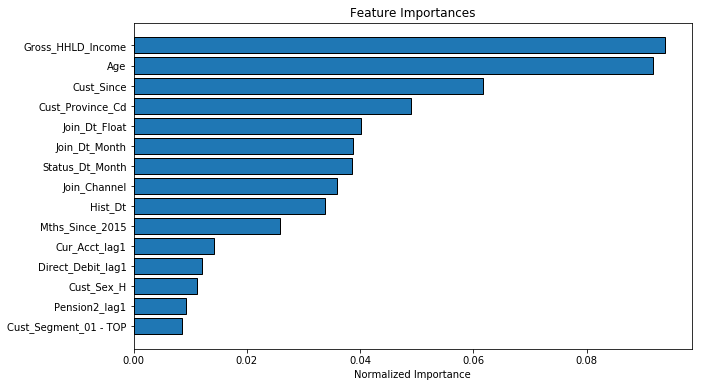

Lag 9: cpu 5215.37, time 5215.37



NameError: name 'cust_list_of_products_bought' is not defined

In [12]:
lags = [9, 10]
xgb_log_loss = {}
xgb_log_loss['lags2'] = 1.0533482898166402
xgb_log_loss['lags3'] = 1.024695578457051
xgb_log_loss['lags4'] = 1.0018815909172973
xgb_log_loss['lags5'] = 0.9968577780164195
xgb_log_loss['lags6'] = 0.9896447322296137
xgb_log_loss['lags7'] = 0.9874258925057015
xgb_log_loss['lags8'] = 0.9839073290157944
for no_of_lags in lags:
    print('**************************Lag {}-Start************************************'.format(no_of_lags))
    with Timer("Lag {}".format(no_of_lags)):
        with Timer("restore data"):
                train = pd.read_pickle("Data/train_transformed_data.pickle")
                train_cols = pickle.load(open("Data/train_cols.pickle", "rb"))
        lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags)
        train = join_with_lag_df(train, lag_dfs)
        test_date = '2016-05-28'
        Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
        test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
        y_true = test_cust_list_of_products_bought
        del test_cust_list_of_products_bought
#         print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
        print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
        y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
        xgb_log_loss['lags'+str(no_of_lags)] = xgb_loss
        del train, train_cols, Xy_train, Xy_validate, y_lag, y_true
    print('**************************Lag {}-End**************************************'.format(no_of_lags))

In [17]:
del  y_lag, y_true

In [18]:
import gc
gc.collect()

3831

In [13]:
xgb_log_loss = {}
xgb_log_loss['lags2'] = 1.0533482898166402
xgb_log_loss['lags3'] = 1.024695578457051
xgb_log_loss['lags4'] = 1.0018815909172973
xgb_log_loss['lags5'] = 0.9968577780164195
xgb_log_loss['lags6'] = 0.9896447322296137
xgb_log_loss['lags7'] = 0.9874258925057015
xgb_log_loss['lags8'] = 0.9839073290157944
xgb_log_loss['lags9'] = 0.9819028170695112
lags = [10,]
for no_of_lags in lags:
    print('**************************Lag {}-Start************************************'.format(no_of_lags))
    with Timer("Lag {}".format(no_of_lags)):
        with Timer("restore data"):
                train = pd.read_pickle("Data/train_transformed_data.pickle")
                train_cols = pickle.load(open("Data/train_cols.pickle", "rb"))
        lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags)
        train = join_with_lag_df(train, lag_dfs)
        test_date = '2016-05-28'
        Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
        test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
        y_true = test_cust_list_of_products_bought
        del test_cust_list_of_products_bought
#         print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
        print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
        y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
        xgb_log_loss['lags'+str(no_of_lags)] = xgb_loss
        del train, train_cols, Xy_train, Xy_validate, y_lag, y_true
    print('**************************Lag {}-End**************************************'.format(no_of_lags))

**************************Lag 10-Start************************************
Lag 10...
restore data...
restore data: cpu 56.49, time 56.49

make lag1 DF...
make lag1 DF: cpu 6.36, time 6.36

make lag2 DF...
make lag2 DF: cpu 6.52, time 6.52

make lag3 DF...
make lag3 DF: cpu 8.79, time 8.79

make lag4 DF...
make lag4 DF: cpu 8.13, time 8.13

make lag5 DF...
make lag5 DF: cpu 8.49, time 8.50

make lag6 DF...
make lag6 DF: cpu 10.51, time 10.52

make lag7 DF...
make lag7 DF: cpu 13.85, time 13.85

make lag8 DF...
make lag8 DF: cpu 10.26, time 10.26

make lag9 DF...
make lag9 DF: cpu 10.66, time 10.66

make lag10 DF...
make lag10 DF: cpu 11.31, time 11.31

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 100.82, time 100.82

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 67.17, time 6

MemoryError: 

In [43]:
xgb_log_loss = {}
xgb_log_loss['lags2'] = 1.0533482898166402
xgb_log_loss['lags3'] = 1.024695578457051
xgb_log_loss['lags4'] = 1.0018815909172973
xgb_log_loss['lags5'] = 0.9968577780164195
xgb_log_loss['lags6'] = 0.9896447322296137
xgb_log_loss['lags7'] = 0.9874258925057015
xgb_log_loss['lags8'] = 0.9839073290157944
xgb_log_loss['lags9'] = 0.9819028170695112
log_loss_lst = []
for k,v in xgb_log_loss.items():
    log_loss_lst.append(v)

Text(0,0.5,'LogLoss')

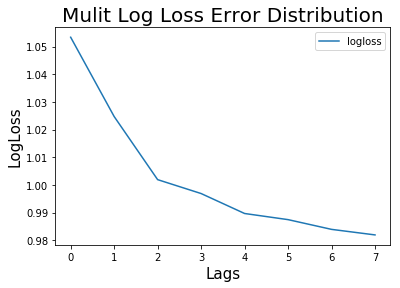

In [47]:
df = pd.DataFrame({'logloss': log_loss_lst})
df.plot()
plt.title("Mulit Log Loss Error Distribution", fontsize=20)
plt.xlabel("Lags", fontsize=15)
plt.ylabel("LogLoss",fontsize=15)

**************************Lag 7-Start************************************
Lag 7...
restore data...
restore data: cpu 55.61, time 55.61

make lag1 DF...
make lag1 DF: cpu 6.69, time 6.69

make lag2 DF...
make lag2 DF: cpu 6.75, time 6.75

make lag3 DF...
make lag3 DF: cpu 7.65, time 7.65

make lag4 DF...
make lag4 DF: cpu 8.27, time 8.27

make lag5 DF...
make lag5 DF: cpu 11.15, time 11.15

make lag6 DF...
make lag6 DF: cpu 7.55, time 7.55

make lag7 DF...
make lag7 DF: cpu 13.60, time 13.60

join train with lag1...
# of records before joining with lag df is 13647309
# of records after joining with lag df is 12682421
join train with lag1: cpu 98.41, time 98.41

join train with lag2...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag2: cpu 68.21, time 68.21

join train with lag3...
# of records before joining with lag df is 12682421
# of records after joining with lag df is 12682421
join train with lag3: cpu 76.02,

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered


Shape of train and validate dataset is (525867, 469)
prepare test data...


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


prepare test data: cpu 11.45, time 11.45

Multi Log loss on Test Data using Random Model is 3.4358677184511444. Our model should get a logloss of less than this.


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[0]	train-mlogloss:2.61105	eval-mlogloss:2.61189
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[10]	train-mlogloss:1.49521	eval-mlogloss:1.5069
[20]	train-mlogloss:1.20131	eval-mlogloss:1.22106
[30]	train-mlogloss:1.07438	eval-mlogloss:1.10211
[40]	train-mlogloss:1.01015	eval-mlogloss:1.04524
[50]	train-mlogloss:0.972685	eval-mlogloss:1.01515
[60]	train-mlogloss:0.948894	eval-mlogloss:0.998335
[70]	train-mlogloss:0.932632	eval-mlogloss:0.98875
[80]	train-mlogloss:0.921139	eval-mlogloss:0.983218
[90]	train-mlogloss:0.912368	eval-mlogloss:0.980136
[100]	train-mlogloss:0.904881	eval-mlogloss:0.978058
[110]	train-mlogloss:0.898862	eval-mlogloss:0.977167
[120]	train-mlogloss:0.893498	eval-mlogloss:0.976781
[130]	train-mlogloss:0.888775	eval-mlogloss:0.976734
[140]	train-mlogloss:0.883974	eval-mlogloss:0.977023
Stopping. Best iteration:
[123]	train-mlogloss:0.892041	eval-mlogloss:0.976724

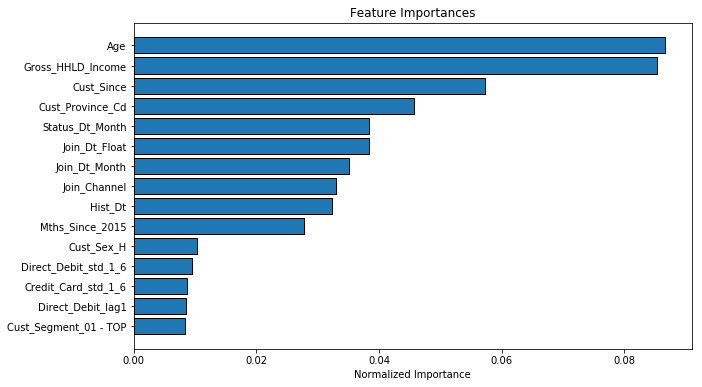

Lag 7: cpu 8032.58, time 8032.58



NameError: name 'xgb_log_loss' is not defined

In [41]:
#since we are running into memory issues we will freeze the # of lags at 7 and 
#add std deviation, min and max to the feature set.

lags = [7,]
for no_of_lags in lags:
    print('**************************Lag {}-Start************************************'.format(no_of_lags))
    with Timer("Lag {}".format(no_of_lags)):
        with Timer("restore data"):
                train = pd.read_pickle("Data/train_transformed_data.pickle")
                train_cols = pickle.load(open("Data/train_cols.pickle", "rb"))
        lag_dfs, train_cols, lag1_features = create_lag_features(train, train_cols, no_of_lags)
        train = join_with_lag_df(train, lag_dfs)
        train, train_cols = create_min_max_std_dev_features(train, train_cols)
        test_date = '2016-05-28'
        Xy_train, Xy_validate = prepare_train_test_split(train, train_cols, test_date, cv=True)
        test_cust_list_of_products_bought, y_lag = prepare_test_data(train, test_date, lag1_features)
        y_true = test_cust_list_of_products_bought
        del test_cust_list_of_products_bought
#         print_class_distributions(Xy_train.y, Xy_validate.y, number_of_classes=len(products))
        print_multi_log_loss_for_random_model(Xy_train.y, Xy_validate.y)
        y_predict, fi_sorted, model, xgb_loss = run_xgb_model(Xy_train, Xy_validate, train_cols)
        xgb_log_loss['lags'+str(no_of_lags)] = xgb_loss
        del train, train_cols, Xy_train, Xy_validate, y_lag, y_true
    print('**************************Lag {}-End**************************************'.format(no_of_lags))